# Main notebook to process indexed datasets into summaries.

## Generate sentence pairs

In [250]:
import itertools
import json
import nltk
import pandas as pd

In [251]:
save_dir = input("enter path to base directory to save outputs to:\n")

enter path to base directory to save outputs to:
 ../data/test8


In [252]:
input_path = input("enter path to indexed dataset:\n")  # default encoding is utf-8
with open(input_path) as f:
    sents_df = pd.read_csv(f, delimiter=',')
sents_df.head()

enter path to indexed dataset:
 ../data/test8/MP3Player.csv


,index,sentence
0,0,each battery lasts about 10-11 hours.
1,1,"the zen micro is a sleek, stylish device that ..."
2,2,"battery life is exceptional, lasting longer th..."
3,3,there are 2 things that need fixing first is t...
4,4,i imagine if i left my player untouched (no ba...


In [253]:
indices = list(sents_df.index)

# generate all pairs in the set of sentences.
indices_list = list(itertools.combinations(indices, 2))
print('no. of sentences: ', len(indices))
print('no. of sentence pairs: ', len(indices_list), '\n')

no. of sentences:  20
no. of sentence pairs:  190 



In [254]:
# generate all sentence pairs and save into a csv for manual labelling.
data = []
for pair in indices_list:
    data.append([pair[0], pair[1], sents_df.iloc[pair[0]]['sentence'], sents_df.iloc[pair[1]]['sentence']])

df = pd.DataFrame(data=data, columns=['first_index', 'second_index', 'first', 'second'])
display(df)

,first_index,second_index,first,second
0,0,1,each battery lasts about 10-11 hours.,"the zen micro is a sleek, stylish device that ..."
1,0,2,each battery lasts about 10-11 hours.,"battery life is exceptional, lasting longer th..."
2,0,3,each battery lasts about 10-11 hours.,there are 2 things that need fixing first is t...
3,0,4,each battery lasts about 10-11 hours.,i imagine if i left my player untouched (no ba...
4,0,5,each battery lasts about 10-11 hours.,"the battery, as others have said, also seems w..."
...,...,...,...,...
185,16,18,the software is simple and straight forward.,"it's easy to use, and makes transfering your c..."
186,16,19,the software is simple and straight forward.,the software that comes along with it is not v...
187,17,18,"the software is very easy to use, and the tran...","it's easy to use, and makes transfering your c..."
188,17,19,"the software is very easy to use, and the tran...",the software that comes along with it is not v...


In [255]:
is_save = input('save indexed paired dataset? (y/n):\n')
if is_save.lower() == 'y':
    df.to_csv(save_dir + '/' + 'paired_sentences.csv')
else:
    print('not saving indexed paired dataset.')

save indexed paired dataset? (y/n):
 y


## Perform inferences of distances between sentences in a sentence pair

In [153]:
import torch
from fairseq.data.data_utils import collate_tokens
from math import exp
import numpy as np

class RobertaMNLI:
    # todo: create similar wrapper classes for other NLI engines.
    # todo: create a wrapper superclass and subclass from there.
    
    def __init__(self, rel_path):
        """
        :param rel_path: relative path to pytorch hub directory.
        """
        self.output_map = {
            0: 'contradiction',
            1: 'neutral',
            2: 'entailment'
        }
        
        torch.hub.set_dir(rel_path)
        self.roberta = torch.hub.load('pytorch/fairseq', 'roberta.large.mnli')  # works
        self.roberta.cuda()
        self.roberta.eval()
        
    def predict_one(self, S1, S2, return_probs=False):
        batch = collate_tokens(
            [self.roberta.encode(S1, S2)], pad_idx=1
        )
        logprobs = self.roberta.predict('mnli', batch)
        classes_tsr = logprobs.argmax(dim=1)
        classes = classes_tsr.tolist()  
        
        if return_probs == True:
            logprobs_list=[logprob.item() for logprob in logprobs[0]]
            prob_list =  [pow(exp(1), logprob) for logprob in logprobs_list]
            return prob_list
        else:
            return classes[0]  # 0 is contradiction, 1 is neutral, 2 is entailment.

In [154]:
predictor = RobertaMNLI(rel_path="../../roberta/hub")

Using cache found in ../../roberta/hub\pytorch_fairseq_master


In [256]:
results = list()
for i in range(len(df)):
    s1 = df.iloc[i]['first']
    s2 = df.iloc[i]['second']
    CNE1 = predictor.predict_one(s1, s2, return_probs=True)
    CNE2 = predictor.predict_one(s2, s1, return_probs=True)
    row = CNE1+ CNE2
    results.append(row)

scores_df = pd.DataFrame(data=results, columns=['C1', 'N1', 'E1', 'C2', 'N2', 'E2'])

In [257]:
def gen_dist2(row):
    '''
    Generate distance score based on Contradiction, Entailment and Neutrality probabilities for both directions.
    Assumes that C+E+N=1.
    '''    
    max1 = max([row['C1'], row['E1'], row['N1']])
    max2 = max([row['C2'], row['E2'], row['N2']])
    if max1 > max2:
        C, E, N = row['C1'], row['E1'], row['N1']
    else:
        C, E, N = row['C2'], row['E2'], row['N2']
    
    if C > 0.5:
        return C
    elif C == E:
        return 0.5
    else:
        return N/(N+E)*0.5

In [258]:
dist_ser = scores_df.apply(lambda row: gen_dist2(row), axis=1)
dist_ser.name = 'dist'
scores_df = scores_df.join(dist_ser)
scores_df = df.join(scores_df)
scores_df.to_csv(save_dir + '/' + 'nliScores.csv')

In [259]:
scores_df.head()

,first_index,second_index,first,second,C1,N1,E1,C2,N2,E2,dist
0,0,1,each battery lasts about 10-11 hours.,"the zen micro is a sleek, stylish device that ...",0.120493,0.868415,0.011092,0.001280,0.997724,0.000997,0.499501
1,0,2,each battery lasts about 10-11 hours.,"battery life is exceptional, lasting longer th...",0.425281,0.561476,0.013243,0.014313,0.532966,0.452722,0.488479
2,0,3,each battery lasts about 10-11 hours.,there are 2 things that need fixing first is t...,0.102561,0.894541,0.002898,0.260592,0.654430,0.084977,0.498385
3,0,4,each battery lasts about 10-11 hours.,i imagine if i left my player untouched (no ba...,0.006200,0.993181,0.000618,0.046462,0.941302,0.012236,0.499689
4,0,5,each battery lasts about 10-11 hours.,"the battery, as others have said, also seems w...",0.001769,0.997358,0.000874,0.002019,0.997144,0.000837,0.499562


## Clustering based on precomputed pairwise distances.

In [260]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=3)
# import scipy
# from scipy.cluster.hierarchy import dendrogram,linkage
# from scipy.cluster.hierarchy import fcluster
# from scipy.cluster.hierarchy import cophenet
# from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

In [261]:
sents_df = pd.read_csv("../data/test8/MP3Player.csv", delimiter=',')
scores_df = pd.read_csv("../data/test8/nliScores.csv", delimiter=',')

In [262]:
# convert pairwise distances to a distance matrix.
# we utilise a pivot table to do this

# first, redundant pairs, e.g. (sentence_1,sentence_1) are missing.
# add the redundant pairs to the df.
# we need this for the pivot function to generate the correct indices and columns.
first = np.unique(scores_df['first_index'].values)
second = np.unique(scores_df['second_index'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
add_data = add_data.astype(np.int)

add_df = pd.DataFrame(data=add_data, columns=['first_index','second_index','dist'])
scores_df = scores_df.append(add_df, ignore_index=True)
df_piv = scores_df.pivot("first_index", "second_index", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [263]:
# generate pairwise matrix for saving.
intersentence = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)
path = save_dir + '/' + 'pairwiseMatrix.csv'
intersentence.to_csv(path)

In [265]:
# LOAD pairwise matrix

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test8/pairwiseMatrix.csv")
print("loaded data from disk.")
display(df_piv.head())
df_piv = df_piv.drop(columns=['first_index'])
display(df_piv.head())
dist_mat = df_piv.values

loaded data from disk.


,first_index,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,0.000000,0.499501,0.488479,0.498385,0.499689,0.499562,0.499525,0.499429,0.499442,...,0.499560,0.499464,0.499640,0.498906,0.499599,0.499474,0.463023,0.484418,0.499378,0.499536
1,1,0.499501,0.000000,0.499551,0.923219,0.499546,0.499673,0.947805,0.498945,0.499060,...,0.499046,0.498462,0.999136,0.993903,0.989903,0.499319,0.499453,0.499354,0.499051,0.499659
2,2,0.488479,0.499551,0.000000,0.974216,0.499409,0.998521,0.999468,0.499324,0.499127,...,0.499579,0.499539,0.499692,0.909942,0.499188,0.499507,0.497870,0.499176,0.499423,0.499679
3,3,0.498385,0.923219,0.974216,0.000000,0.499496,0.499616,0.743863,0.499104,0.499021,...,0.498632,0.499142,0.499336,0.491827,0.499333,0.498906,0.980102,0.980462,0.498987,0.499605
4,4,0.499689,0.499546,0.499409,0.499496,0.000000,0.499607,0.499481,0.499487,0.499585,...,0.499460,0.499494,0.499651,0.498446,0.494485,0.499590,0.499556,0.499649,0.499591,0.499534


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000,0.499501,0.488479,0.498385,0.499689,0.499562,0.499525,0.499429,0.499442,0.484586,0.499560,0.499464,0.499640,0.498906,0.499599,0.499474,0.463023,0.484418,0.499378,0.499536
1,0.499501,0.000000,0.499551,0.923219,0.499546,0.499673,0.947805,0.498945,0.499060,0.496263,0.499046,0.498462,0.999136,0.993903,0.989903,0.499319,0.499453,0.499354,0.499051,0.499659
2,0.488479,0.499551,0.000000,0.974216,0.499409,0.998521,0.999468,0.499324,0.499127,0.495346,0.499579,0.499539,0.499692,0.909942,0.499188,0.499507,0.497870,0.499176,0.499423,0.499679
3,0.498385,0.923219,0.974216,0.000000,0.499496,0.499616,0.743863,0.499104,0.499021,0.948330,0.498632,0.499142,0.499336,0.491827,0.499333,0.498906,0.980102,0.980462,0.498987,0.499605
4,0.499689,0.499546,0.499409,0.499496,0.000000,0.499607,0.499481,0.499487,0.499585,0.497995,0.499460,0.499494,0.499651,0.498446,0.494485,0.499590,0.499556,0.499649,0.499591,0.499534


In [271]:
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
condensed_mat = squareform(dist_mat)
linkage = 'complete'

clusters = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage=linkage, distance_threshold=0.49)
clusters.fit_predict(dist_mat)

# use metric to measure/compare goodness of clusters based on internal coherence and 
# external coupling. we can consider maximising the Dunn index.
# or consider average sillhouette width (maximise), which is available in sklearn.
silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
print(clusters.n_clusters_, ": ", silhouette_avg)

17 :  0.016725789923952954


In [272]:
# sil_scores_arr = np.asarray(sil_scores)
# print('max avg silhouette score: ', sil_scores_arr.max())
# OPTIMAL_K = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
# print('nclusters w max avg silhouette score: ', OPTIMAL_K)

In [273]:
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(sents_df.iloc[idx]['sentence'])
    print('\n')

cluster 0 (size 2):
[12 13]


'but my biggest gripe is still the extremely ugly design.'

'but, the creative zen micro is plagued by a serious, serious stupid and elemenatary design flaw.'



cluster 1 (size 2):
[ 0 16]


'each battery lasts about 10-11 hours.'

'the software is simple and straight forward.'



cluster 2 (size 1):
[19]


'the software that comes along with it is not very intuitive but once you are used to it, it does the job well.'



cluster 3 (size 2):
[ 9 11]


'Creative did an awesome job with the design.'

'it was a good player when it worked and i loved the design.'



cluster 4 (size 1):
[18]


"it's easy to use, and makes transfering your cd collection to the player a cinch."



cluster 5 (size 1):
[7]


'the earbud headphones are really nice.'



cluster 6 (size 1):
[10]


'the design is very nice, and the colors are too.'



cluster 7 (size 1):
[17]


'the software is very easy to use, and the transfer is super fast!'



cluster 8 (size 1):
[8]


'the earbuds are great headphones. as good as my agk studio 240, well not as good but darn close.'



cluster 9 (size 1):
[15]


'creative has excellent music software, a very responsive tech support group (they are quick on firmware updates, and make them publicly available), and usually a good array of accessories.'



cluster 10 (size 1):
[5]


'the battery, as others have said, also seems weaker than Creative suggests.'



cluster 11 (size 1):
[6]


'the battery life leaves a lot to be desired.'



cluster 12 (size 1):
[3]


'there are 2 things that need fixing first is the battery life. it will run for 6 hrs without problems with medium usage of the buttons.'



cluster 13 (size 1):
[1]


"the zen micro is a sleek, stylish device that caters not just to 'hip' youngsters but to people of all walks of life who like to listen on the go without having to worry frequently about battery life, size, or the 'awkward' factor."



cluster 14 (size 1):
[2]


'battery life is exceptional, lasting longer than the 8-10 hours that seem reasonable with most music players on the market.'



cluster 15 (size 1):
[14]


"i thought it could've been designed a bit better."



cluster 16 (size 1):
[4]


'i imagine if i left my player untouched (no backlight) it could play for considerably more than 12 hours at a low volume level.'

In [274]:
import json
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(int(df_piv.index[idx]))
    clusters_dict[i] = sents

path = save_dir + '/' + 'clusters.json'
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

In [169]:
# DEPRECATED
# Compute the distance of one cluster to another cluster using average pairwise distance
# between two elements (one in each cluster).  
# print('------')
# print(f'\nno. of clusters = {n_clusters}')
# # find average distances between clusters and output a new distance matrix
# labels = [i for i in range(clusters.n_clusters_)]
# avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
# for i in range(clusters.n_clusters_):
#     indices = np.where(clusters.labels_ == i)[0]
#     labels.remove(i)
#     for j in labels:
#         other_indices = np.where(clusters.labels_ == j)[0]
#         intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))

#         for k, index in enumerate(indices):
#             for m, other_index in enumerate(other_indices):
#                 intra_dist_arr[k][m] = dist_mat[index][other_index]

#         #print (f'cluster {i} against cluster {j}:')
#         #print(intra_dist_arr)

#         avg_dist = np.average(intra_dist_arr)
#         #print(avg_dist)
#         avg_dist_arr[i][j] = avg_dist
# print(avg_dist_arr)

## Visualise network of clusters

In [ ]:
import networkx as nx
import string

In [ ]:
G = nx.from_numpy_matrix(tmp)
print(G.nodes())
print(G.edges().data())
#G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

import pydot
from networkx.drawing.nx_pydot import write_dot

print("using package pydot")
path = save_dir + '/' + 'clusterViz.dot'
write_dot(G, path)
# you can then use the various graphviz CLI to generate the image. E.g. "neato -Tpng clusterViz.dot -o clusterViz.png"
# see https://www.graphviz.org/pdf/neatoguide.pdf for more info on modifying dot files.
# fdp or sfdp can be used instead of neato. 

## Summarize

In [275]:
# LOAD DATA

import numpy as np

# load indexed sentences:
sents_df = pd.read_csv("../data/test8/MP3Player.csv")

# load intersentence pairwise distance matrix.
df_piv = pd.read_csv("../data/test8/pairwiseMatrix.csv")
df_piv = df_piv.drop(columns=['first_index'])
dist_mat = df_piv.values

# load clusters.
with open("../data/test8/clusters.json") as fp:
    tmp = json.load(fp)

clusters_dict = dict()
for str_idx, cluster in tmp.items():
    clusters_dict[int(str_idx)] = cluster
    
print("loaded data from disk.")
display(clusters_dict)

loaded data from disk.


{0: [12, 13],
 1: [0, 16],
 2: [19],
 3: [9, 11],
 4: [18],
 5: [7],
 6: [10],
 7: [17],
 8: [8],
 9: [15],
 10: [5],
 11: [6],
 12: [3],
 13: [1],
 14: [2],
 15: [14],
 16: [4]}

## Reliability Ranking approach to multi-summarization.

In [276]:
import itertools
def intra_clust_dis_mat(clust, pairwise):
    """
    :param clust: list of sentence indices that form the cluster.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: 
    """
    sorted_clust = sorted(clust)
    pairs = list(itertools.combinations(clust, 2))
    tmp = np.zeros((len(clust), len(clust)))
    for pair in pairs:
        tmp_idx0 = sorted_clust.index(pair[0])
        tmp_idx1 = sorted_clust.index(pair[1])
        tmp[tmp_idx0][tmp_idx1] = pairwise[pair[0], pair[1]]
    intraclust = tmp + np.transpose(tmp)
    return intraclust, sorted_clust


def generate_intraclusts(clusters_dict, pairwise):
    """
    :param clusters_dict: cluster_index: list(indices of sentences in that cluster)}.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: dict {cluster_idx: (asc_sorted_indices, intraclust_dist_mat)}. the ascending sorted indices corresponds/aligns
    to the row or col index of the dist mat.
    """
    clusters_dict2 = dict()
    for i, _  in clusters_dict.items():
        intraclust, sorted_clust = intra_clust_dis_mat(clusters_dict[i], pairwise)
        clusters_dict2[i] = (sorted_clust, intraclust)
    return clusters_dict2


from lexrank.lexrank import degree_centrality_scores
def choose_salient(dis_mat, clust):
    """
    :param dis_mat: disimilarity or distance matrix. every value is between 0-1, inclusive.
    :clust: list of sentence indices corresponding to the row-indexing of dis_mat.
    :returns: sentence index of most salient sentence.
    """
    similarity_matrix = 1 - dis_mat
    #print(similarity_matrix)
    scores = degree_centrality_scores(similarity_matrix, threshold=None)
    #print(scores)
    return clust[np.argmax(scores)]
    
def interclust_dist_mat(clusters, pairwise):
    """
    compute intercluster distances based on the distance between the most salient elements of each cluster.
    :param clusters: dict {cluster_idx: (sent_indices, intraclust_dist_mat)}. indices align to rows of intraclust dist matrix.
    the cluster indices must always start from 0.
    :param pairwise: numpy.ndarray of pairwise dist matrix of all points. AKA affinity matrix.
    :returns: intercluster distance matrix.
    """
    # find salient sentence (index) of each cluster.
    salient_indices = dict()
    for cluster_idx, val in clusters.items():
        indices = val[0]
        intraclust = val[1]
        salient_idx = choose_salient(intraclust, indices)
        salient_indices[cluster_idx] = salient_idx
    
    # generate intercluster dist matrix.
    interclust = np.zeros((len(clusters), len(clusters)))
    for i in range(len(interclust)):
        for j in range(len(interclust)):
            sent_idx1 = salient_indices[i]
            sent_idx2 = salient_indices[j]
            interclust[i][j] = pairwise[sent_idx1][sent_idx2]
    return interclust

In [277]:
def rank_by_reliability(clusters_dict, intercluster, contra_threshold=0.5):
    """
    :param clusters_dict: dict of clusters. {cluster index: list(sentence indices)}.
    :param intercluster: square numpy.ndarray representing distances between each cluster.
    :return scores: list((score, cluster_idx)) 
    """
    scores = list()
    for cluster_idx in range(len(intercluster)):
        contra_size = 0
        for other_cluster_idx in range(len(intercluster)):
            if intercluster[cluster_idx][other_cluster_idx] > contra_threshold:
                contra_size = contra_size + len(clusters_dict[other_cluster_idx])
        numer = len(clusters_dict[cluster_idx])
        if contra_size > 0:
            denom = contra_size
        else:
            denom = 1
        score = numer/denom
        scores.append((score, cluster_idx))
    return sorted(scores, reverse=True)

In [278]:
clusters_dict2 = generate_intraclusts(clusters_dict, dist_mat)  # clusters_dict with intracluster dist matrix.

intercluster_dists = interclust_dist_mat(clusters_dict2, dist_mat)
path = save_dir + '/' + 'clusterDistances.csv'
np.savetxt(path, intercluster_dists, delimiter=",")

scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)

In [279]:
# print out clusters and most salient sentences for each cluster, in descending order of "reliability". 
for score, idx in sorted(scores, reverse=True):
    print(f"cluster name: {idx}")
    print(f"cluster size: {len(clusters_dict[idx])}")
    print(f"reliability score: {score}")
    display(sents_df.iloc[clusters_dict[idx]])
    
    intraclust = clusters_dict2[idx][1]
    sorted_clust = clusters_dict2[idx][0]
    salient_idx = choose_salient(intraclust, sorted_clust)
    display(sents_df.iloc[salient_idx]['sentence'])
#     print(intraclust)
    print('======\n')

cluster name: 1
cluster size: 2
reliability score: 2.0


,index,sentence
0,0,each battery lasts about 10-11 hours.
16,16,the software is simple and straight forward.


'each battery lasts about 10-11 hours.'


cluster name: 16
cluster size: 1
reliability score: 1.0


,index,sentence
4,4,i imagine if i left my player untouched (no ba...


'i imagine if i left my player untouched (no backlight) it could play for considerably more than 12 hours at a low volume level.'


cluster name: 10
cluster size: 1
reliability score: 1.0


,index,sentence
5,5,"the battery, as others have said, also seems w..."


'the battery, as others have said, also seems weaker than Creative suggests.'


cluster name: 9
cluster size: 1
reliability score: 1.0


,index,sentence
15,15,"creative has excellent music software, a very ..."


'creative has excellent music software, a very responsive tech support group (they are quick on firmware updates, and make them publicly available), and usually a good array of accessories.'


cluster name: 2
cluster size: 1
reliability score: 0.5


,index,sentence
19,19,the software that comes along with it is not v...


'the software that comes along with it is not very intuitive but once you are used to it, it does the job well.'


cluster name: 3
cluster size: 2
reliability score: 0.4


,index,sentence
9,9,Creative did an awesome job with the design.
11,11,it was a good player when it worked and i love...


'Creative did an awesome job with the design.'


cluster name: 14
cluster size: 1
reliability score: 0.3333333333333333


,index,sentence
2,2,"battery life is exceptional, lasting longer th..."


'battery life is exceptional, lasting longer than the 8-10 hours that seem reasonable with most music players on the market.'


cluster name: 8
cluster size: 1
reliability score: 0.3333333333333333


,index,sentence
8,8,the earbuds are great headphones. as good as m...


'the earbuds are great headphones. as good as my agk studio 240, well not as good but darn close.'


cluster name: 6
cluster size: 1
reliability score: 0.25


,index,sentence
10,10,"the design is very nice, and the colors are too."


'the design is very nice, and the colors are too.'


cluster name: 5
cluster size: 1
reliability score: 0.25


,index,sentence
7,7,the earbud headphones are really nice.


'the earbud headphones are really nice.'


cluster name: 0
cluster size: 2
reliability score: 0.25


,index,sentence
12,12,but my biggest gripe is still the extremely ug...
13,13,"but, the creative zen micro is plagued by a se..."


'but my biggest gripe is still the extremely ugly design.'


cluster name: 13
cluster size: 1
reliability score: 0.2


,index,sentence
1,1,"the zen micro is a sleek, stylish device that ..."


"the zen micro is a sleek, stylish device that caters not just to 'hip' youngsters but to people of all walks of life who like to listen on the go without having to worry frequently about battery life, size, or the 'awkward' factor."


cluster name: 4
cluster size: 1
reliability score: 0.2


,index,sentence
18,18,"it's easy to use, and makes transfering your c..."


"it's easy to use, and makes transfering your cd collection to the player a cinch."


cluster name: 12
cluster size: 1
reliability score: 0.16666666666666666


,index,sentence
3,3,there are 2 things that need fixing first is t...


'there are 2 things that need fixing first is the battery life. it will run for 6 hrs without problems with medium usage of the buttons.'


cluster name: 7
cluster size: 1
reliability score: 0.16666666666666666


,index,sentence
17,17,"the software is very easy to use, and the tran..."


'the software is very easy to use, and the transfer is super fast!'


cluster name: 15
cluster size: 1
reliability score: 0.14285714285714285


,index,sentence
14,14,i thought it could've been designed a bit better.


"i thought it could've been designed a bit better."


cluster name: 11
cluster size: 1
reliability score: 0.09090909090909091


,index,sentence
6,6,the battery life leaves a lot to be desired.


'the battery life leaves a lot to be desired.'

In [280]:
def summarize(clusters, intercluster, sent_df, intersentence, coherence_threshold=0.6, redundancy_threshold=0.1):
    """
    :param clusters: dict of clusters of the form {cluster_idx: list(sentence_indices)}.
    :param intercluster: numpy.ndarray of inter-cluster distances in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param intersentence: numpy.ndarray of inter-sentence distances in pairwise matrix form.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: lowest distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception("coherence_threshold <= redundancy_threshold.")
    
    scores = rank_by_reliability(clusters, intercluster, contra_threshold=0.6) # each element is (score, cluster_index)
    ranked_clusters = sorted(scores, reverse=True)
    print(ranked_clusters)
    
    compress_rate = 0.2
    num_sent = int(compress_rate * len(ranked_clusters))
        
    def create_coherent_summary(ordered_clusters):
        # this summary does not contain contradictions within itself.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[cluster_idx], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            salient_sent = sents_df.iloc[salient_idx]['sentence']
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence[sent_idx][salient_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(salient_idx)
        return summary
    
    def create_free_summary(ordered_clusters):
        # this summary is just formed from the most salient sentence of ea cluster. no regards to whether
        # appending the next sentence would cause the summary to be self-contradicted.
        summary = list()
        for score, cluster_idx in ordered_clusters:
            intraclust, sorted_cluster = intra_clust_dis_mat(clusters[cluster_idx], intersentence)
            salient_idx = choose_salient(intraclust, sorted_cluster)
            summary.append(salient_idx)
        return summary
    
    top_summa = create_coherent_summary(ranked_clusters[:num_sent])
    btm_summa = create_free_summary(ranked_clusters[-1*num_sent:])
    btm_summa.reverse()  # reverse so that most unreliable (least agreed statement) is at the top.
    
    return top_summa, btm_summa

In [281]:
summaries = summarize(clusters_dict, intercluster_dists, sents_df, dist_mat)
for summa in summaries:
    print(len(summa))

[(2.0, 1), (1.0, 16), (1.0, 10), (1.0, 9), (0.5, 2), (0.4, 3), (0.3333333333333333, 14), (0.3333333333333333, 8), (0.25, 6), (0.25, 5), (0.25, 0), (0.2, 13), (0.2, 4), (0.16666666666666666, 12), (0.16666666666666666, 7), (0.14285714285714285, 15), (0.09090909090909091, 11)]
3
3


In [282]:
print("relatively agreeable summary statements:")
for idx in summaries[0]:
    print(sents_df.iloc[idx]['sentence'])
print()
print("relatively disagreeable summary statements")
for idx in summaries[1]:
    print(sents_df.iloc[idx]['sentence'])

relatively agreeable summary statements:
each battery lasts about 10-11 hours.
i imagine if i left my player untouched (no backlight) it could play for considerably more than 12 hours at a low volume level.
the battery, as others have said, also seems weaker than Creative suggests.

relatively disagreeable summary statements
the battery life leaves a lot to be desired.
i thought it could've been designed a bit better.
the software is very easy to use, and the transfer is super fast!


In [222]:
# def prune_and_print(summary, sent_limit):
#     i = 0
#     while i < sent_limit and i < len(summary):
#         sent_idx = summary[len(summary)-1-i]
#         print(sents_df.iloc[sent_idx]['sentence'])
#         i = i + 1

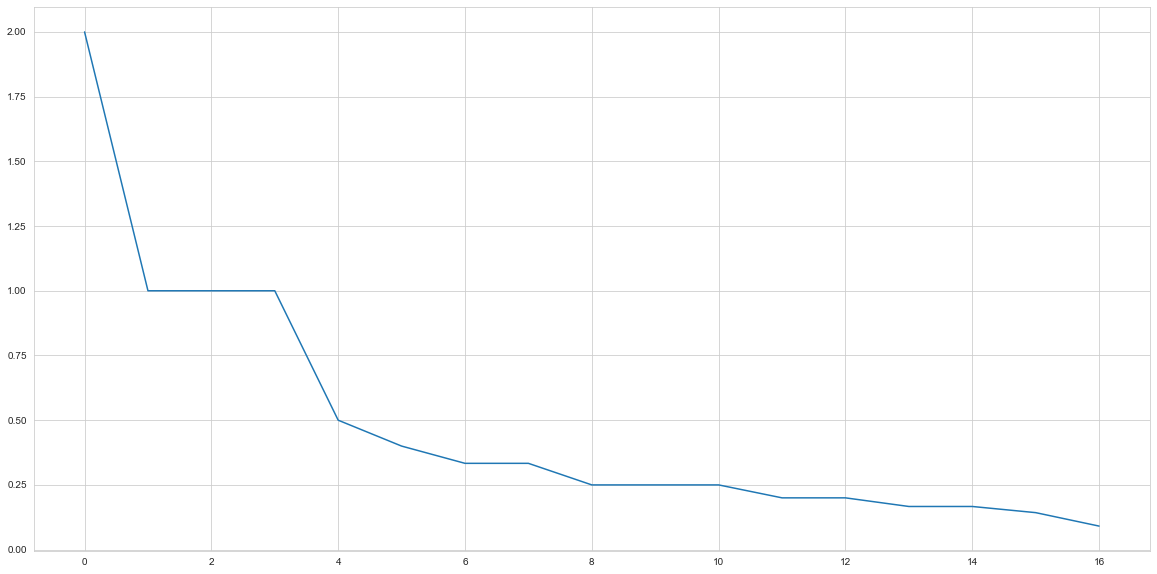

In [283]:
scores = rank_by_reliability(clusters_dict, intercluster_dists, contra_threshold=0.6)
sorted_clusters = sorted(scores, reverse=True)  # each element is (score, cluster_index)
scores_only = [score for score, _ in sorted_clusters]
import matplotlib.pyplot as plt
plt.plot(scores_only)

## Previous Single Summary Algo.

In [ ]:
from nltk.tokenize import RegexpTokenizer

def choose_longest(sentences):
    tokenizer = RegexpTokenizer(r'\w+')
    max_len = 0
    final_sent = None
    for sent in sentences:
        tokens = tokenizer.tokenize(sent)
        if len(tokens) > max_len:
            max_len = len(sent)
            final_sent = sent
    return final_sent

from lexrank import LexRank
from lexrank.mappings.stopwords import STOPWORDS
def choose_salient(sentences):
    """
    
    """
    lxr = LexRank(sentences, stopwords=STOPWORDS['en'])
    top_sentence = lxr.get_summary(sentences[0], summary_size=1, threshold=.1)
    return top_sentence[0]
    

def summarize(clusters, intersentence, sent_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.3):
    """
    :param clusters: dict of clusters of the form {str(cluster_num): list(sentence_indices)}.
    :param intersentence: Pandas DataFrame of precomputed inter-sentence distance in pairwise matrix form.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param coherence_threshold: maximum distance allowed for a sentence pair within the summary. valid values between 0-1.
    :param redundancy_threshold: minimum distance allowed for a sentence pair within the summary. valid values between 0-1.
    
    We need a redundancy_threshold because the clustering algorithm does not always manage to group 
    redundant sentences together?
    """
    if coherence_threshold <= redundancy_threshold:
        raise Exception
    
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    summary = list()
    word_count = 0
    
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    
    for key, clust in sorted_clusters:
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        #selected = choose_longest(clust)
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        tokens = tokenizer.tokenize(selected)
        if word_count + len(tokens) < word_limit:
            max_dist = 0
            min_dist = 1
            for sent_idx in summary:
                dist = intersentence.iloc[sent_idx][selected_idx]
                if dist > max_dist:
                    max_dist = dist
                if dist < min_dist:
                    min_dist = dist
            if max_dist < coherence_threshold and min_dist > redundancy_threshold:
                summary.append(selected_idx)
                word_count = word_count + len(tokens)
        else:
            break
    return summary

In [ ]:
# test lexrank algorithm.
sentences = [sents_df.iloc[idx]['sentence'] for idx in clusters_dict['0']]
display(sentences)
choose_salient([sentences])

In [ ]:
# todo: think of statistical way to determine the coherence_threshold and redundancy_threshold.
summary = summarize(clusters_dict, intersentence, sents_df, word_limit=90, coherence_threshold=0.6, redundancy_threshold=0.35)
print("no. of sentences in summary: ", len(summary))
print("no. of sentences in source: ", len(intersentence.index.values))
print()
for sent_idx in summary:
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")
print()
for sent_idx in sorted(summary):
    print(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}")

## Multiple Summaries (deprecated)

In [ ]:
def multi_summary(clusters, intercluster_dists, sent_df, word_limit=100, contradiction_threshold=0.6):
    """
    :param clusters: dict of clusters of the form {str(cluster_index): list(sentence_indices)}.
    :param intercluster_dists: square numpy.ndarray representing distances between each cluster.
    :param sent_df: Pandas DataFrame of indexed sentences.
    :param word_limit: maximum num of words for summary.
    :param contradiction_threshold: float value between 0 and 1, representing the value after which
    sentence pairs will be considered contradictory.
    """
    # find top/representative sentence of each cluster.
    top_sentences = dict()
    for clust_idx, clust in clusters.items():
        sentences = [sent_df.iloc[idx]['sentence'] for idx in clust]
        selected = choose_salient([sentences])
        selected_idx = sent_df[sent_df.sentence == selected].index[0]
        top_sentences[int(clust_idx)] = selected_idx  # typecasted to int because json dicts saved integer keys into str keys.
    
    # find clusters that are not contradictory w ALL other clusters.
    base_clusters = list()
    contradicted_pairs = list()
    contradicted_set= set()
    for i in range(len(intercluster_dists)):
        for j in range(i+1,len(intercluster_dists)):
            if intercluster_dists[i][j] > contradiction_threshold:
                contradicted_pairs.append((i,j))
                contradicted_set.add(i)
                contradicted_set.add(j)
        if i not in contradicted_set:
            base_clusters.append(i)
    
    # construct base summary
    base_summary = list()
    word_count = 0
    tokenizer = RegexpTokenizer(r'\w+') # tokenize into word-like tokens.
    sorted_clusters = sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)  # iterable of pairs.
    for clust_idx, clust in sorted_clusters:
        if int(clust_idx) in base_clusters:
            selected_idx = top_sentences[int(clust_idx)]
            selected = sent_df.iloc[selected_idx]['sentence']
            tokens = tokenizer.tokenize(selected)
            if word_count + len(tokens) < word_limit:
                base_summary.append(selected_idx)
                word_count = word_count + len(tokens)
            else:
                break
    
    # construct summaries w contentious information.
    all_summaries = list()
    added_sentences = set()
    for clust1, clust2 in contradicted_pairs:
        sent1 =  top_sentences[clust1]
        sent2 =  top_sentences[clust2]
        
        if sent1 not in added_sentences:
            all_summaries.append(base_summary + [sent1])
            added_sentences.add(sent1)
        if sent2 not in added_sentences:
            all_summaries.append(base_summary + [sent2])
            added_sentences.add(sent2)
    print(base_summary)
    return all_summaries, base_summary

In [ ]:
from IPython.display import Markdown
all_summaries, base_summary = multi_summary(clusters_dict, intercluster_dists, sents_df, word_limit=90, contradiction_threshold=0.6)

print(f"total no. of summaries = {len(all_summaries)}")
print()

for summary in all_summaries:
    print("no. of sentences in summary: ", len(summary))
    print("no. of sentences in source: ", len(intersentence.index.values))
    print()
    for sent_idx in sorted(summary):
        if sent_idx in base_summary:
            display(Markdown(f"**{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}**"))
        else:
            display(Markdown(f"{sent_idx}: {sents_df.iloc[sent_idx]['sentence']}"))
    print()